# Attempts at decreasing the visibility of perturbations

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
import math
import torchvision.models as models
from PIL import Image
from deepfool.deepfool import deepfool, local_deepfool, deepfool_specific
import os
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import copy


from utils import diff, plot_diff, plot_comparaison, make_examples

In [2]:
import random

NUM_CLASSES = 100
MAX_ITER = 100
OVERSHOOT = 0.02
TARGET_CLASS = 413

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

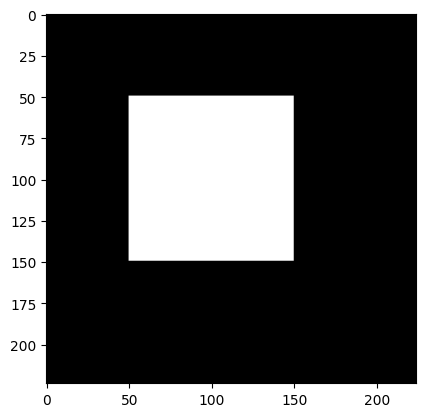

In [3]:
region_mask = np.zeros((224, 224), dtype=np.int32)
region_mask[50:150, 50:150] = 1


plt.imshow((region_mask))
plt.imshow(region_mask, cmap="gray")
plt.show()

region_mask = None

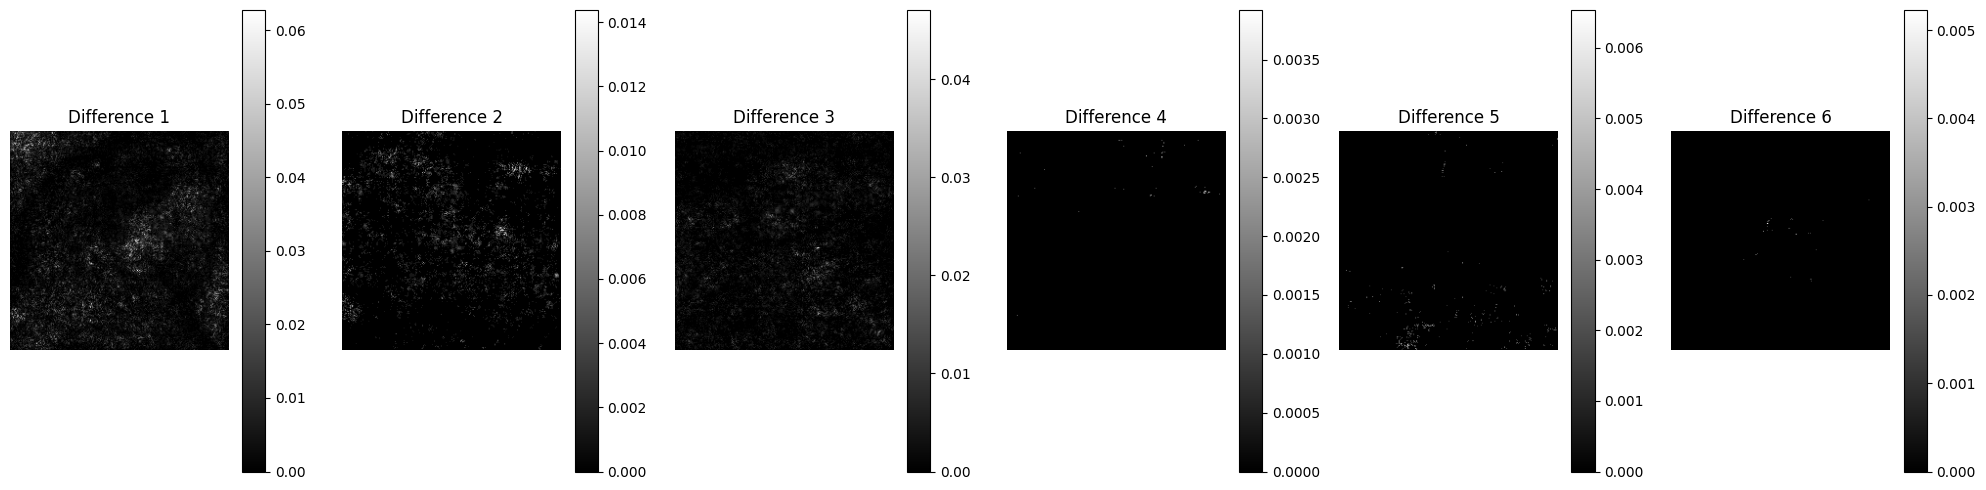

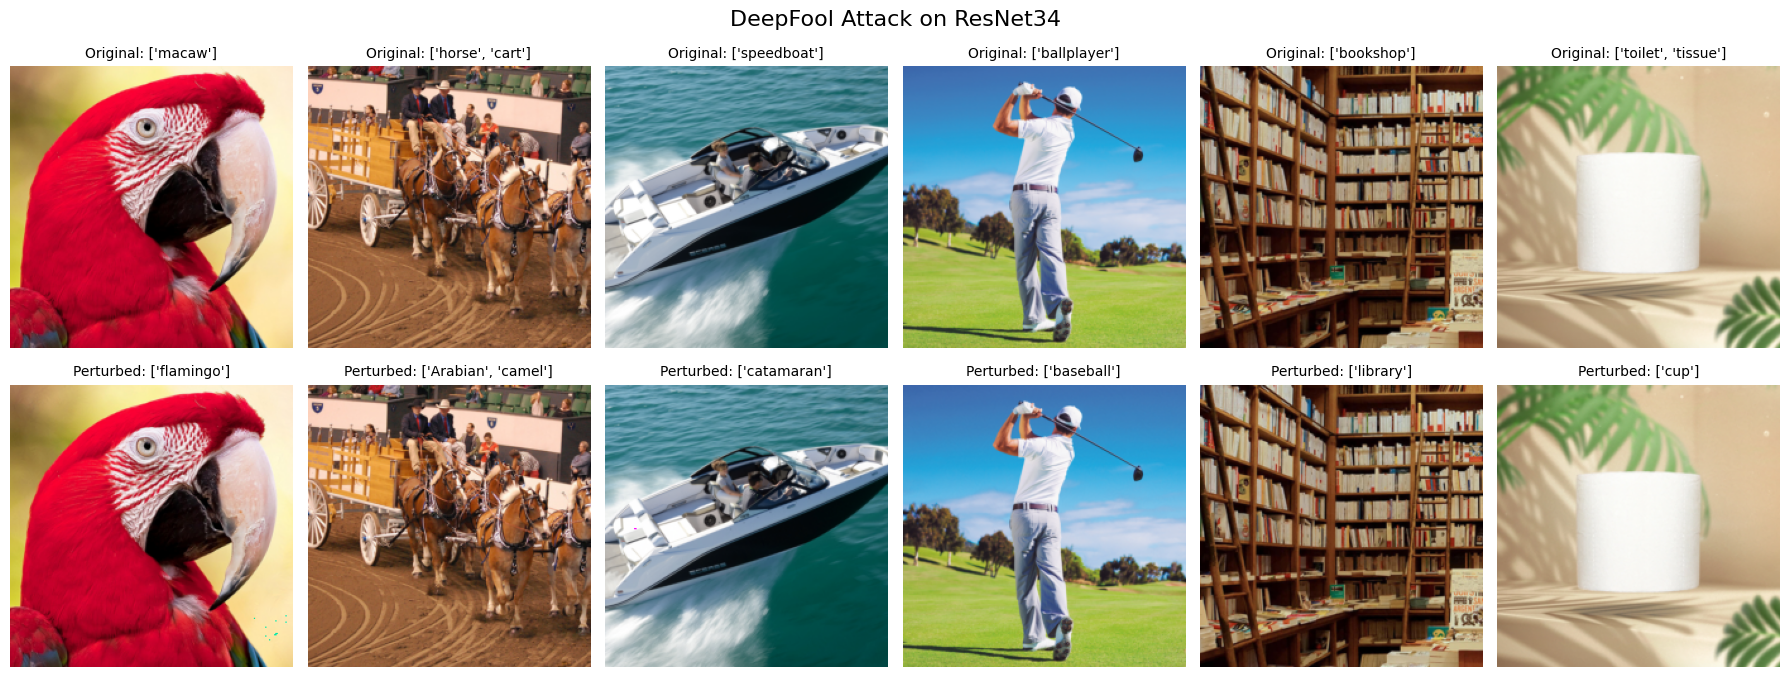

In [4]:
local_deepfool_args = {
    "num_classes": NUM_CLASSES,  # Number of classes
    "overshoot": OVERSHOOT,  # Maximum perturbation allowed
    "max_iter": MAX_ITER,  # Maximum number of iterations
    "region_mask": region_mask,  # Region mask for the image
}


(
    original_images,
    original_labels,
    original_images_norm,
    perturbed_images,
    perturbed_labels,
    perturbed_images_norm,
) = make_examples(local_deepfool, local_deepfool_args)

plot_diff(original_images_norm, perturbed_images_norm)

plot_comparaison(original_images, perturbed_images, original_labels, perturbed_labels)

\begin{equation}
	\hat{l}(x_0) = \arg \min_{k \neq \hat{k}} \frac{|f_{k}(x_0) - f_{\hat{k}}(x_0)|}{\|w_{k} - w_{\hat{k}}\|_2} +  \gamma * ||w_{k}||_\infty
\end{equation}

This first equation represents the closest classification frontier to approach, with $k$ being the original class of $x_0$, and $\hat{k}$ another class. $f_k$ represents the classification function output for a given class $k$, and $w_k$ is the direction vector of said function for a given class. When we know what classification $\hat{k}$ is the closest, we can compute the minimal perturbation to get the image to pass the frontier and be classified as $\hat{k}$ :

\begin{equation}
	r_*(x_0) = \frac{|f_{\hat{l}(x_0)}(x_0) - f_k(x_0)|}{\|w_{\hat{l}(x_0)} - w_k\|_2^2} (w_{\hat{l}(x_0)} - w_k)
\end{equation}

In [5]:
def regular_inf_local_deepfool(
    image,
    net,
    num_classes=10,
    overshoot=0.02,
    max_iter=50,
    region_mask=None,
    decay_factor=2,
):
    is_cuda = torch.cuda.is_available()
    if is_cuda:
        image = image.cuda()
        net = net.cuda()

    input_shape = image.cpu().numpy().shape

    f_image = (
        net.forward(image.unsqueeze(0).requires_grad_(True))
        .detach()
        .cpu()
        .numpy()
        .flatten()
    )

    I = np.argsort(f_image)[::-1][:num_classes]
    label_orig = I[0]

    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    iter = 0
    x = pert_image.unsqueeze(0).requires_grad_(True)
    pred_p = net.forward(x)
    label_pert = label_orig

    while label_pert == label_orig and iter < max_iter:
        pert = np.inf

        pred_p[0, label_orig].backward(retain_graph=True)
        grad_origin = x.grad.detach().cpu().numpy().copy()

        for k in range(1, num_classes):
            x.grad.zero_()

            pred_p[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.detach().cpu().numpy().copy()

            w_k = np.zeros_like(cur_grad)

            if region_mask is None:
                w_k[0] = cur_grad[0] - grad_origin[0]
            else:
                w_k[0] = (cur_grad[0] - grad_origin[0]) * region_mask

            f_k = (pred_p[0, I[k]] - pred_p[0, label_orig]).item()  # Eq 8 in the paper
            # ! The norm of the perturbation is calculated differently from the paper
            pert_k = abs(f_k) / np.linalg.norm(
                w_k.flatten()
            ) + decay_factor * np.linalg.norm(
                w_k.flatten(), np.inf
            ) / np.linalg.norm(w_k) # Eq 8 in the paper

            if pert_k < pert:
                pert = pert_k
                w = w_k

        r_i = pert * w / np.linalg.norm(w)  # Eq : 9
        if region_mask is None:
            r_tot += r_i[0]
        else:
            r_tot += r_i[0] * region_mask

        pert_image = image + torch.from_numpy(r_tot).to(image.device)

        x = pert_image.unsqueeze(0).requires_grad_(True)
        input = x.view(x.size()[-4:]).type(
            torch.cuda.FloatTensor if is_cuda else torch.FloatTensor
        )

        pred_p = net.forward(input)
        label_pert = np.argmax(pred_p.detach().cpu().numpy().flatten())

    r_tot = (1 + overshoot) * r_tot
    return r_tot, iter, label_orig, label_pert, pert_image

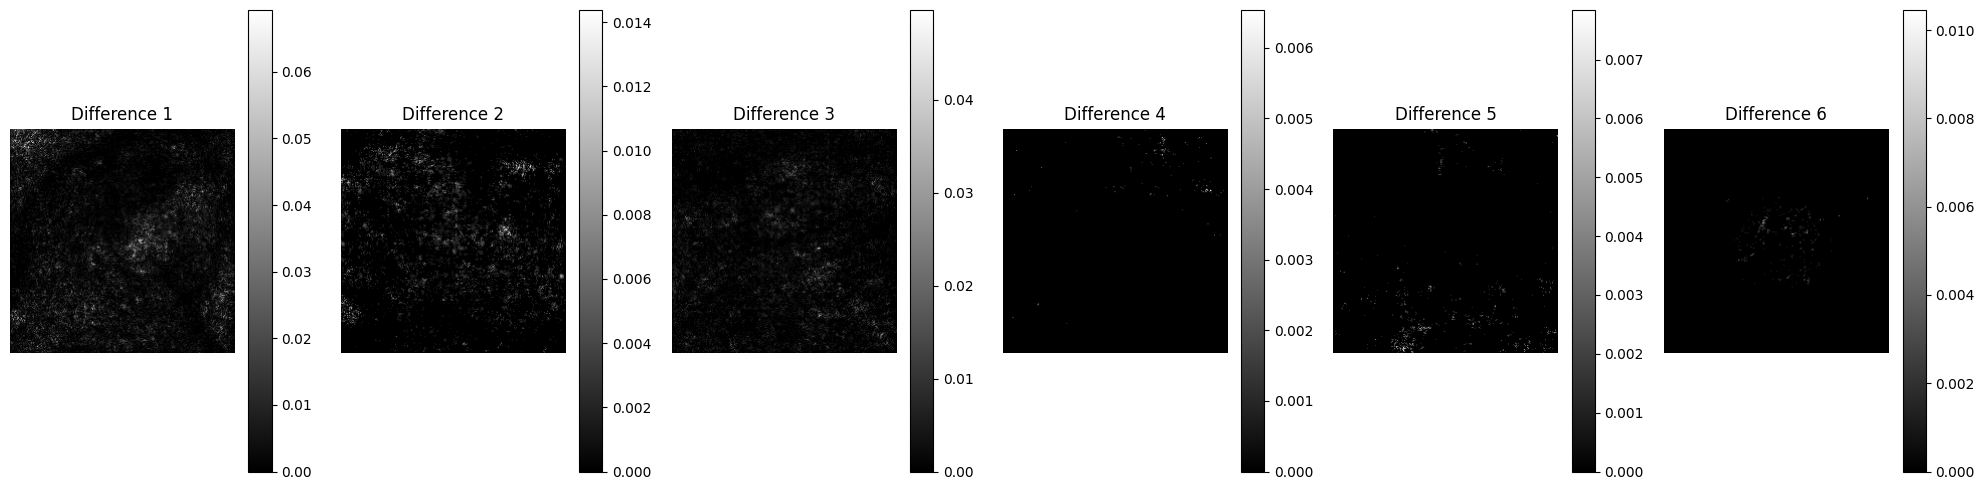

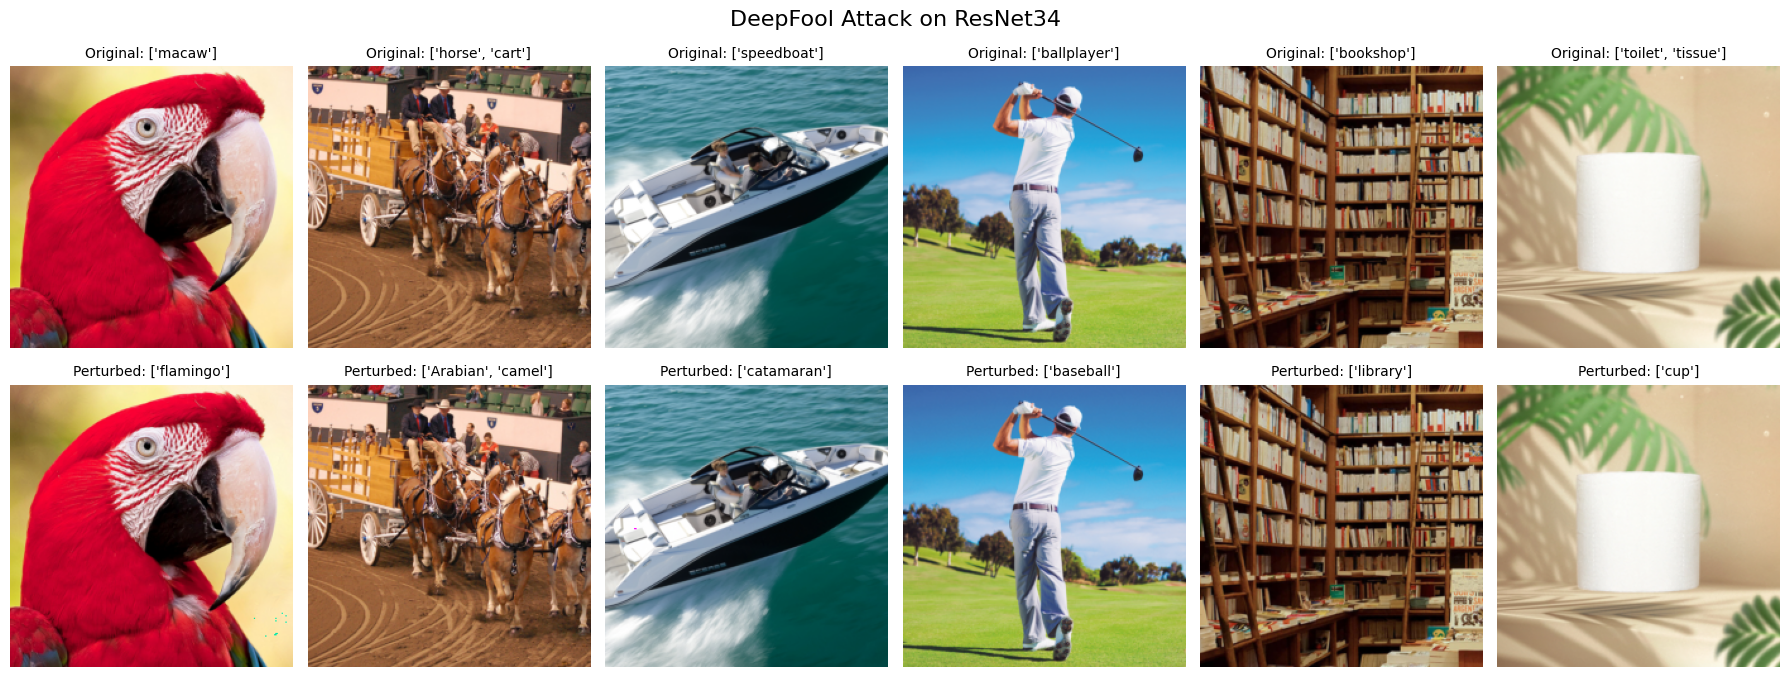

In [6]:
local_deepfool_args = {
    "num_classes": NUM_CLASSES,  # Number of classes
    "overshoot": OVERSHOOT,  # Maximum perturbation allowed
    "max_iter": MAX_ITER,  # Maximum number of iterations
    "region_mask": region_mask,  # Region mask for the image
    "decay_factor": 2,  # Decay factor
}


(
    inf_original_images,
    inf_original_labels,
    inf_original_images_norm,
    inf_perturbed_images,
    inf_perturbed_labels,
    inf_perturbed_images_norm,
) = make_examples(regular_inf_local_deepfool, local_deepfool_args)  # noqa: F821

plot_diff(inf_original_images_norm, inf_perturbed_images_norm)

plot_comparaison(
    inf_original_images, inf_perturbed_images, inf_original_labels, inf_perturbed_labels
)

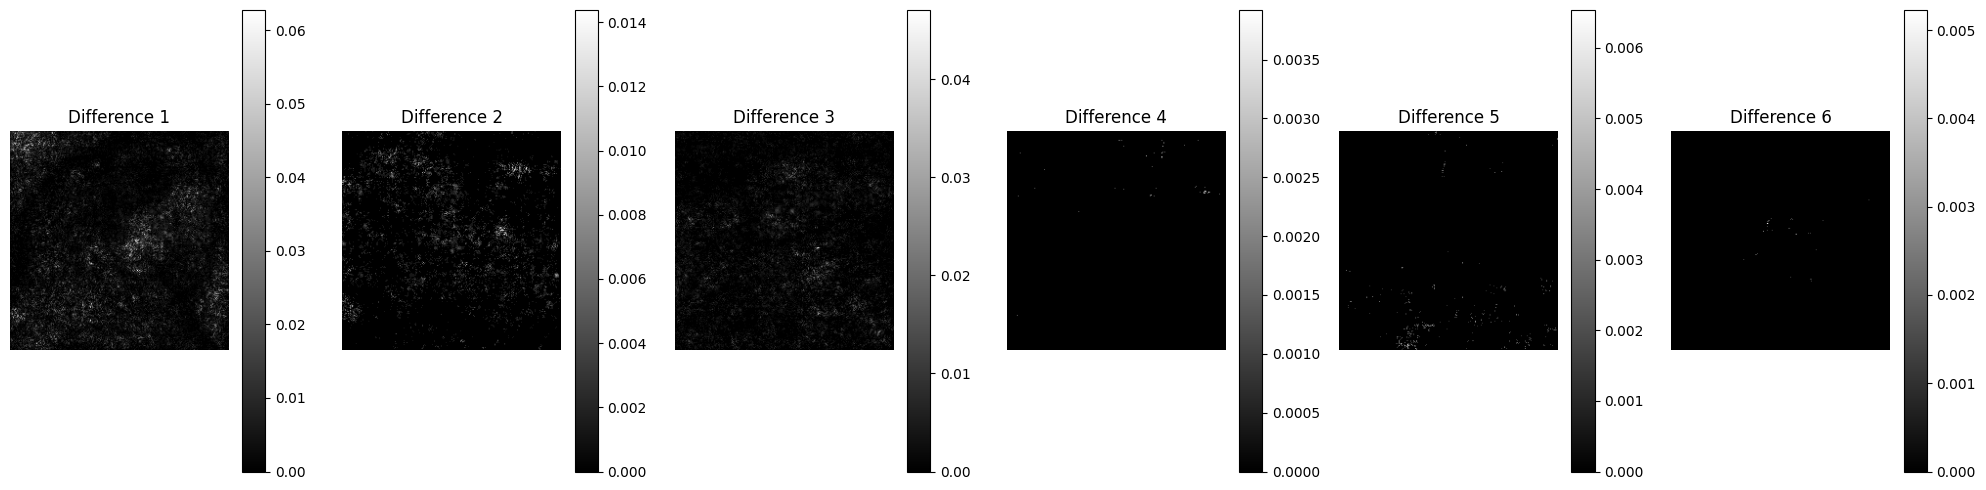

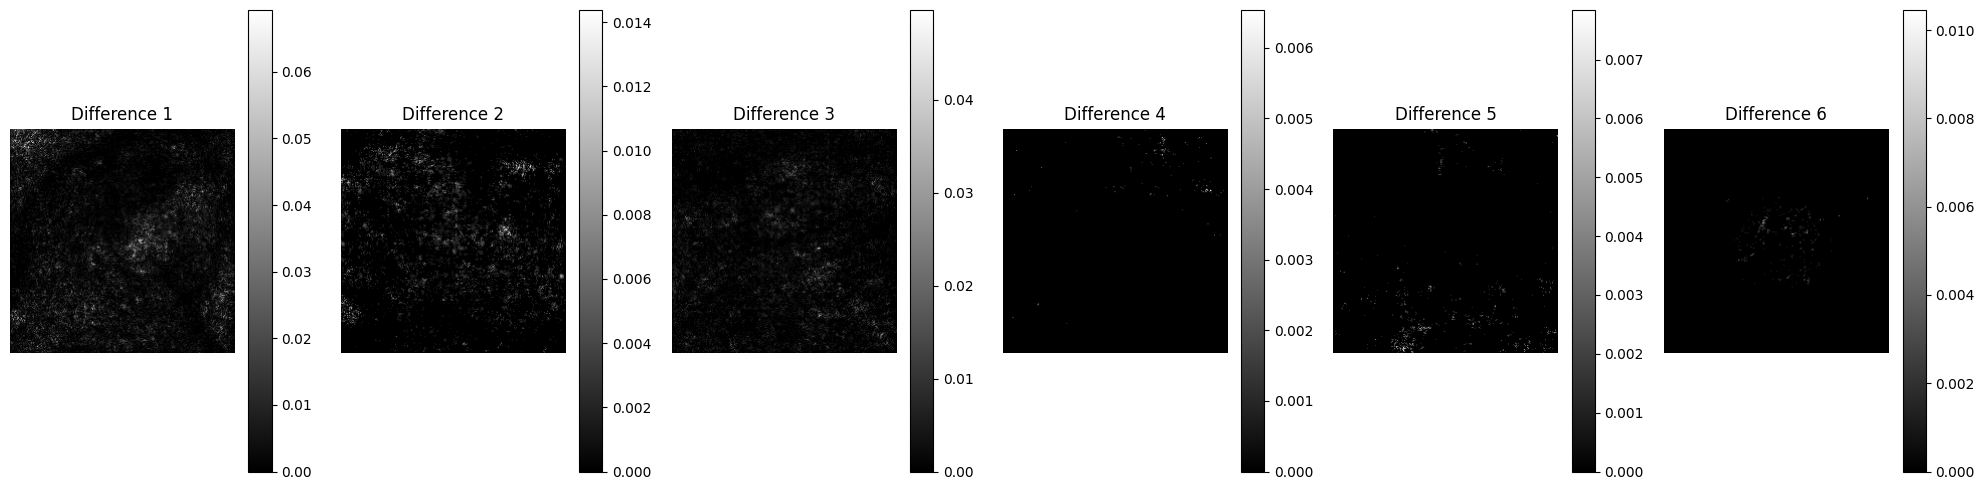

In [7]:
plot_diff(original_images_norm, perturbed_images_norm)
plot_diff(inf_original_images_norm, inf_perturbed_images_norm)

In [8]:
def min_inf_local_deepfool(
    image,
    net,
    num_classes=10,
    overshoot=0.02,
    max_iter=50,
    region_mask=None,
    decay_factor=2,
):
    is_cuda = torch.cuda.is_available()
    if is_cuda:
        image = image.cuda()
        net = net.cuda()

    input_shape = image.cpu().numpy().shape

    f_image = (
        net.forward(image.unsqueeze(0).requires_grad_(True))
        .detach()
        .cpu()
        .numpy()
        .flatten()
    )

    I = np.argsort(f_image)[::-1][:num_classes]
    label_orig = I[0]

    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)
    r_i = np.ones(input_shape)

    iter = 0
    x = pert_image.unsqueeze(0).requires_grad_(True)
    pred_p = net.forward(x)
    label_pert = label_orig

    while label_pert == label_orig and iter < max_iter:
        pert = np.inf

        pred_p[0, label_orig].backward(retain_graph=True)
        grad_origin = x.grad.detach().cpu().numpy().copy()

        for k in range(1, num_classes):
            x.grad.zero_()

            pred_p[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.detach().cpu().numpy().copy()

            w_k = np.zeros_like(cur_grad)

            if region_mask is None:
                w_k[0] = cur_grad[0] - grad_origin[0]
            else:
                w_k[0] = (cur_grad[0] - grad_origin[0]) * region_mask

            f_k = (pred_p[0, I[k]] - pred_p[0, label_orig]).item()  # Eq 8 in the paper
            pert_k = abs(f_k) / np.linalg.norm(w_k.flatten())  # Eq 8 in the paper

            # ! Finding the smallest infinite norm of perturbation
            pert = pert_k
            w = w_k
            
            new_r_i = pert * w / np.linalg.norm(w)  # Eq : 9
            
            if region_mask is not None:
                new_r_i[0] = new_r_i[0] * region_mask
            
            # print(r_i.shape, new_r_i[0].shape,np.linalg.norm(new_r_i, axis=1).shape, np.linalg.norm(r_i, axis=0).shape)
            # print(np.linalg.norm(np.linalg.norm(new_r_i, axis=0).flatten(), np.inf), np.linalg.norm(np.linalg.norm(r_i, axis=0).flatten(), np.inf))
            # if np.linalg.norm(np.linalg.norm(new_r_i, axis=0).flatten(), np.inf) < np.linalg.norm(np.linalg.norm(r_i, axis=0).flatten(), np.inf):
            if np.linalg.norm(new_r_i) < np.linalg.norm(r_i):
                r_i = new_r_i
            # ! End of the modification

        r_tot += r_i[0]

        pert_image = image + torch.from_numpy(r_tot).to(image.device)

        x = pert_image.unsqueeze(0).requires_grad_(True)
        input = x.view(x.size()[-4:]).type(
            torch.cuda.FloatTensor if is_cuda else torch.FloatTensor
        )

        pred_p = net.forward(input)
        label_pert = np.argmax(pred_p.detach().cpu().numpy().flatten())

    r_tot = (1 + overshoot) * r_tot
    return r_tot, iter, label_orig, label_pert, pert_image

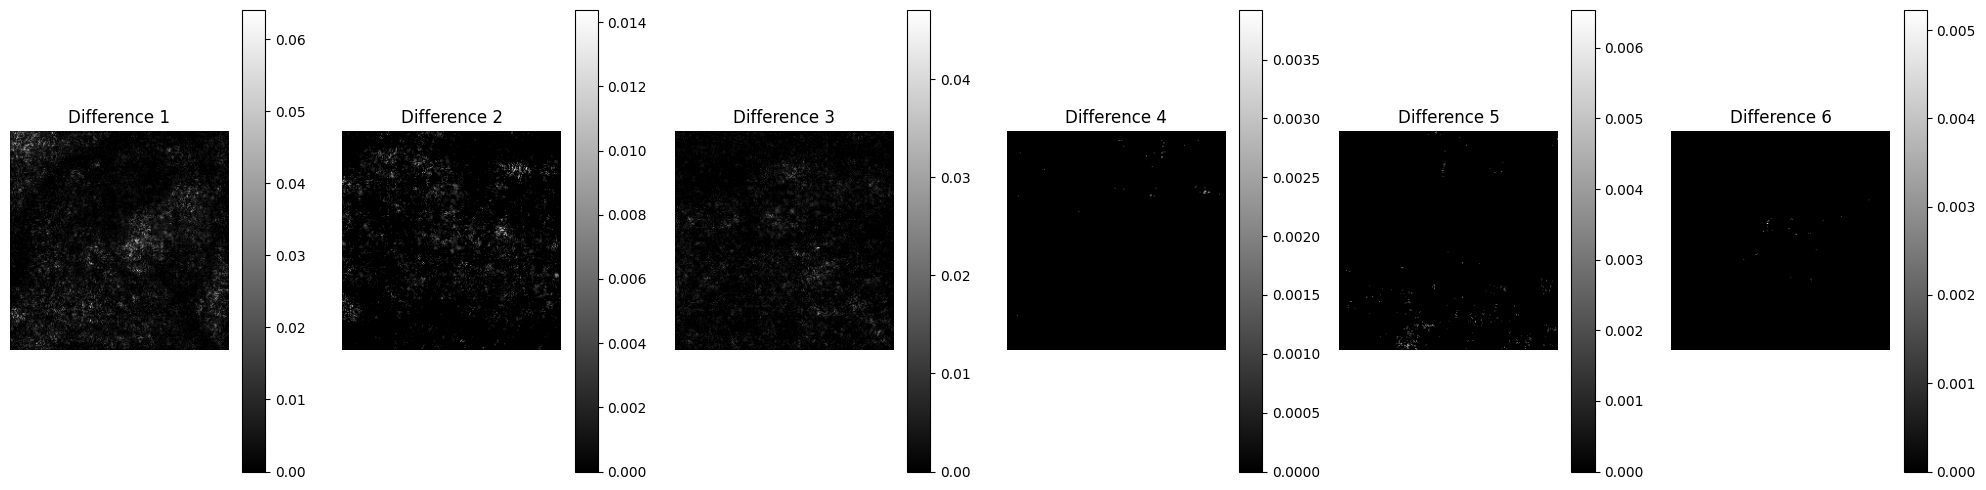

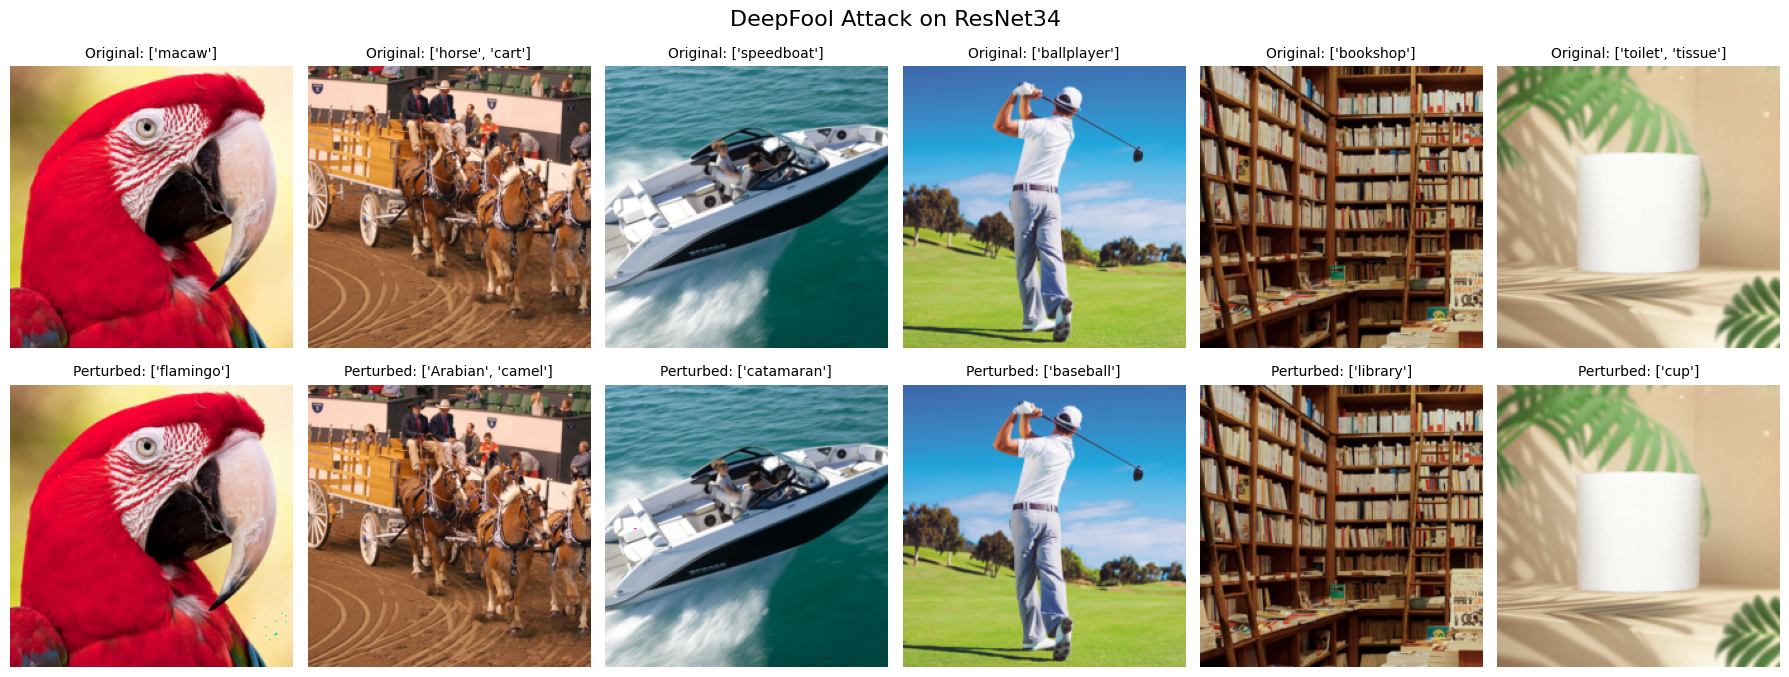

In [9]:
local_deepfool_args = {
    "num_classes": NUM_CLASSES,  # Number of classes
    "overshoot": OVERSHOOT,  # Maximum perturbation allowed
    "max_iter": MAX_ITER,  # Maximum number of iterations
    "region_mask": region_mask,  # Region mask for the image
    "decay_factor": 2,  # Decay factor
}


(
    min_original_images,
    min_original_labels,
    min_original_images_norm,
    min_perturbed_images,
    min_perturbed_labels,
    min_perturbed_images_norm,
) = make_examples(min_inf_local_deepfool, local_deepfool_args)  # noqa: F821

plot_diff(min_original_images_norm, min_perturbed_images_norm)

plot_comparaison(
    min_original_images, min_perturbed_images, min_original_labels, min_perturbed_labels
)

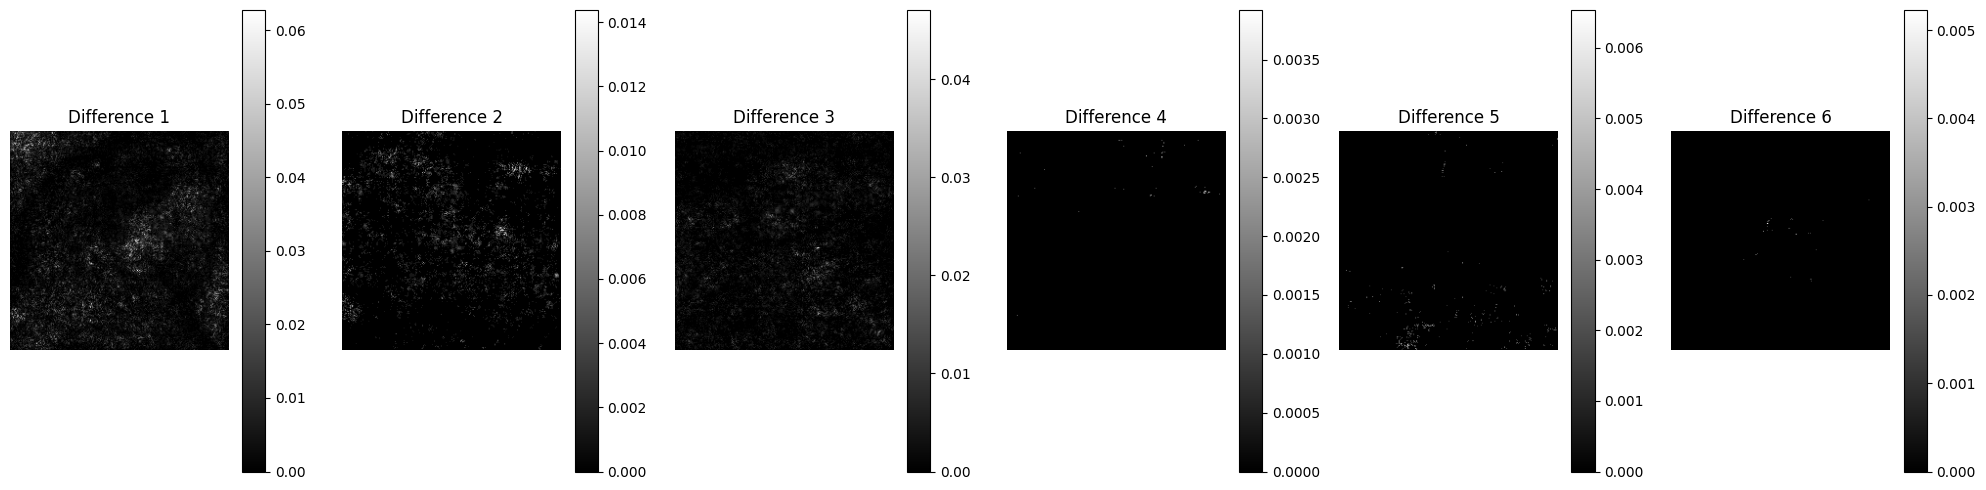

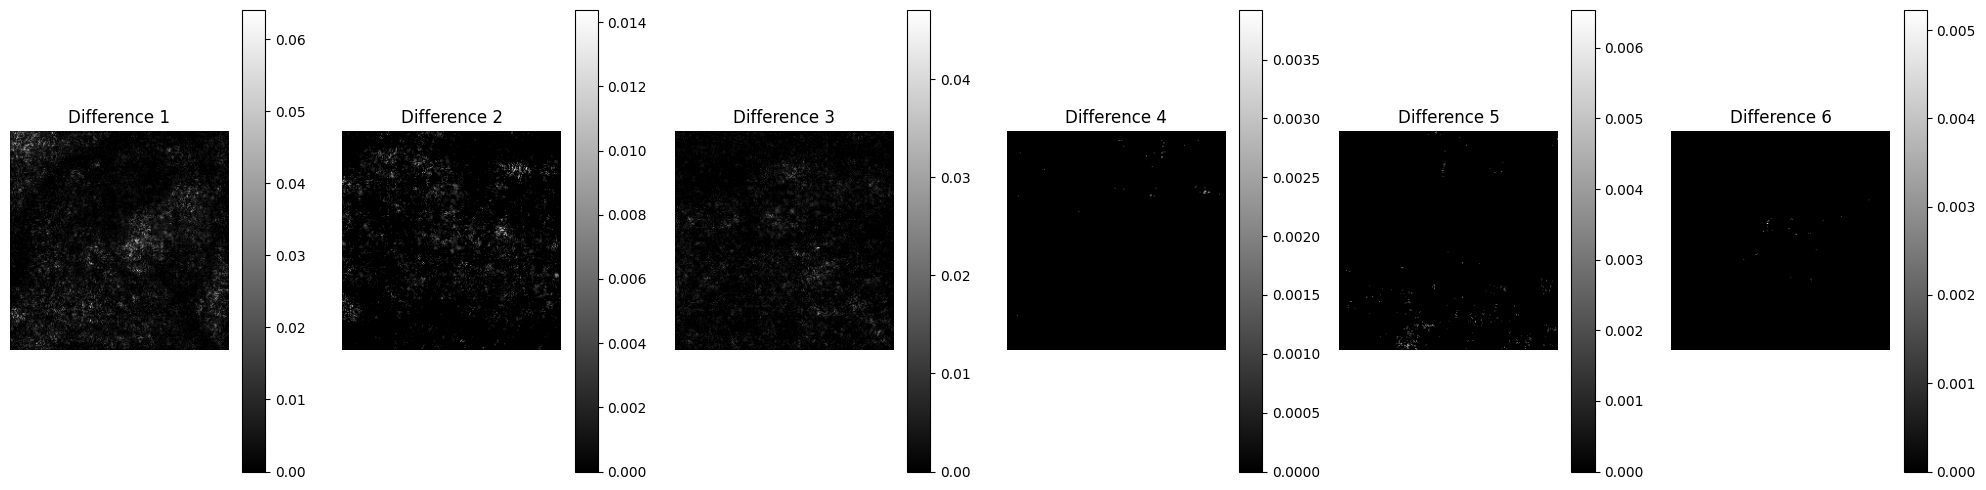

In [10]:
plot_diff(original_images_norm, perturbed_images_norm)
plot_diff(min_original_images_norm, min_perturbed_images_norm)

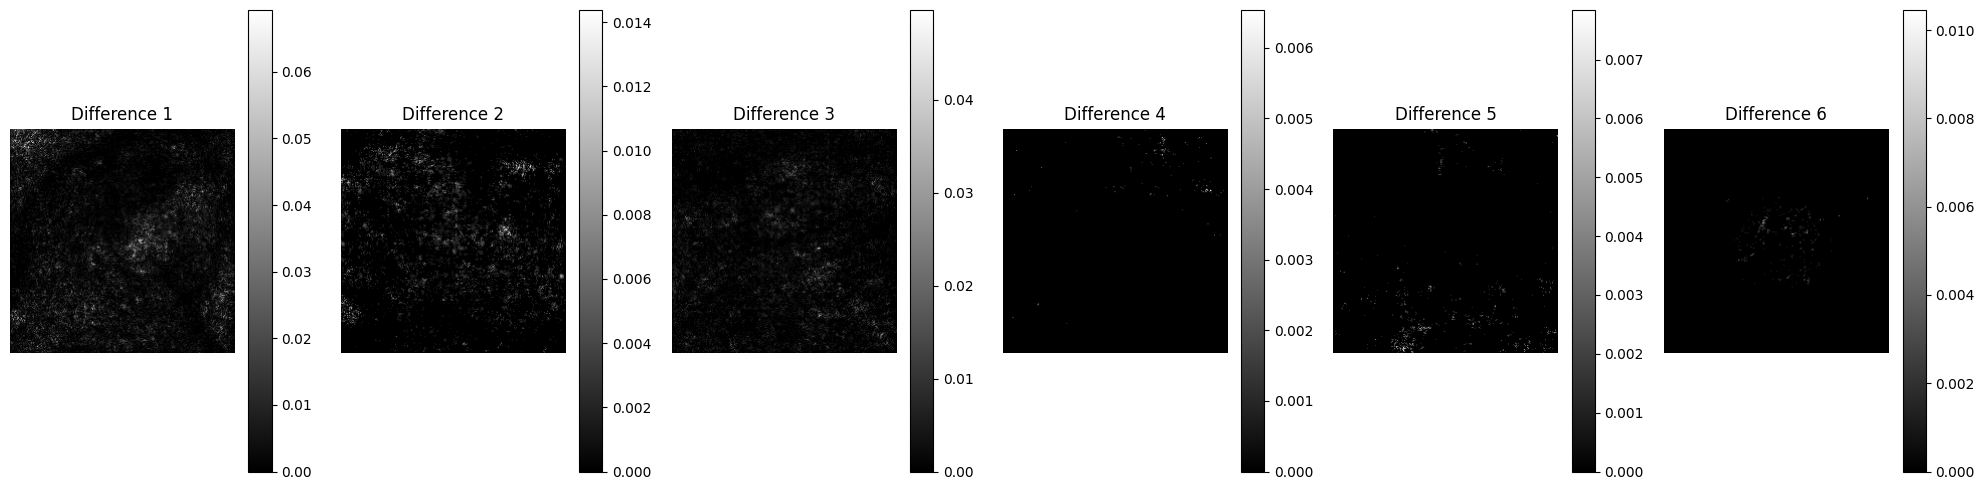

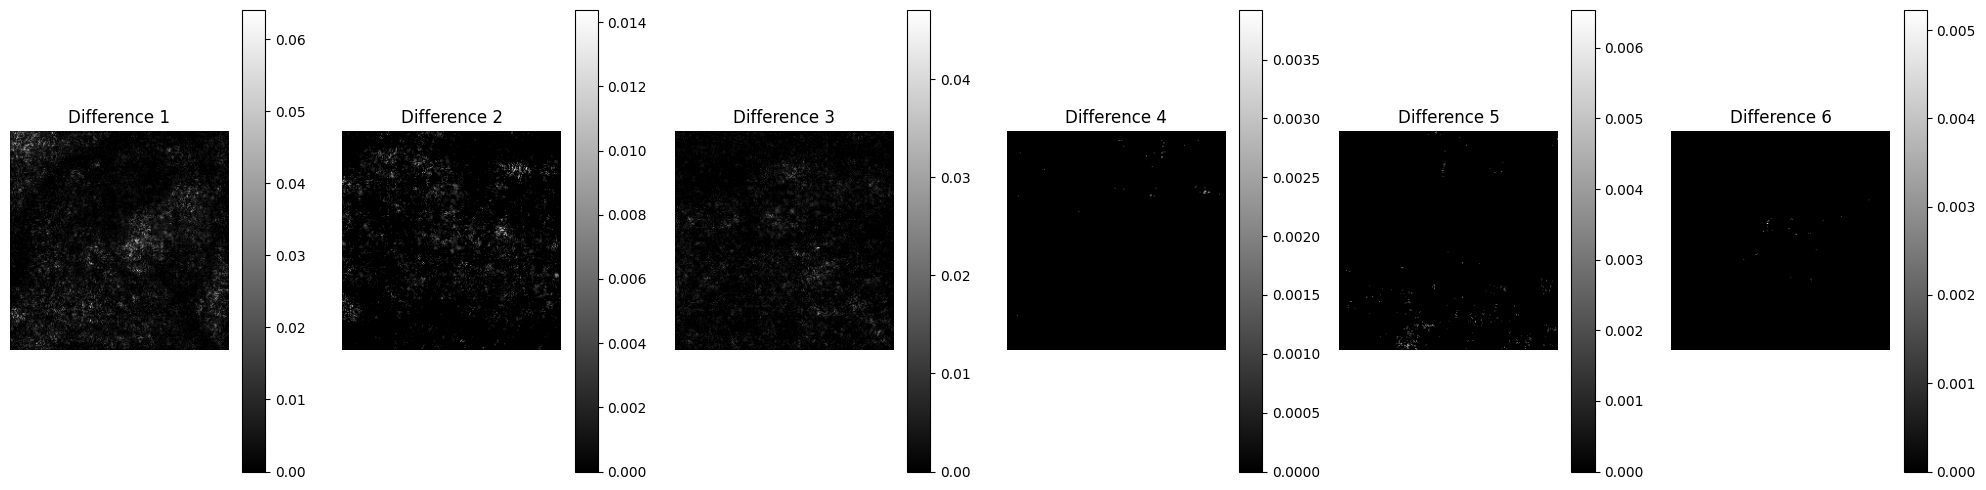

In [11]:
plot_diff(inf_original_images_norm, inf_perturbed_images_norm)
plot_diff(min_original_images_norm, min_perturbed_images_norm)